In [1]:
from scipy.io import loadmat
import numpy as np
import jax
from jax import numpy as jnp

import sys
sys.path.append('..')
from src.dynamics import *
from src.environment import *
from src.containers import *
from utils.test_utils import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = loadmat("IRTmesh.mat")

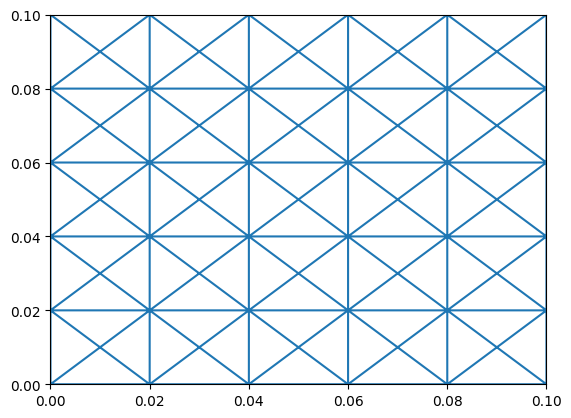

In [3]:
xy = np.asarray([data["NODE"][0,i][2,0][:,0] for i in range(data["NODE"].size)])
x = xy[:,0]
y = xy[:,1]
tri = np.asarray([data["CELL"][0,i][6:9][:,0] for i in range(data["CELL"].size)])-1
plt.triplot(x,y,tri)
plt.axis([0,.1,0,.1])
plt.show()

In [4]:
# Given physical parameters
Re = 100            # Reynolds number
nu = 0.1     # physical kinematic viscosity
L = 100             # domain length (physical units)
dx = 1           # spatial step (physical units)
dt = 0.1            # time step (physical units)

# Speed of sound squared for D2Q9 lattice
c_s_sq = 1.0 / 3.0

# Convert to lattice units
U_lattice = Re * nu / L

# Compute relaxation time tau
Tau = nu / c_s_sq + 0.5

# Print results
print(f"Lid velocity (lattice units): {U_lattice:.5f}")
print(f"Relaxation time tau: {Tau:.5f}")
U_lid = U_lattice

Lid velocity (lattice units): 0.10000
Relaxation time tau: 0.80000


In [5]:
Environment.dynamics = D2Q9(tau=Tau,delta_t = dt)

env = Environment.create(data["CELL"].size,data["FACE"].size,data["NODE"].size)

In [6]:
cell_order = np.array([cell[0] for cell in data["CELL"][0,:]],dtype=np.int32)-1
cell_faces = np.array([cell[15:18] for cell in data["CELL"][0,:]],dtype=np.int32)[...,0]-1
def get_normal_dir(cell_index):
    cell_faces = np.asarray([data["CELL"][0,cell_index][i][0][0] for i in range(15,18)],dtype=np.int32)-1
    cell_normals = np.asarray([data["CELL"][0,cell_index][i][0][0] for i in range(33,36)],dtype=np.float32)
    face_normals = np.asarray([data["FACE"][0,i][3][0][0] for i in cell_faces.flatten()],dtype=np.float32)
    signs = np.sign([np.dot(cell_normals[i], face_normals[i]) for i in range(3)])
    return signs
cell_normals = np.array([get_normal_dir(i) for i in range(len(cell_order))])

/var/folders/2n/7nnz5dsd7j51q45dv749mhth0000gn/T/ipykernel_66276/3802725191.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cell_order = np.array([cell[0] for cell in data["CELL"][0,:]],dtype=np.int32)-1
/var/folders/2n/7nnz5dsd7j51q45dv749mhth0000gn/T/ipykernel_66276/3802725191.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cell_faces = np.array([cell[15:18] for cell in data["CELL"][0,:]],dtype=np.int32)[...,0]-1


In [7]:
env.cells.face_indices = jnp.asarray(cell_faces,jnp.int32)
env.cells.face_normals = jnp.asarray(cell_normals,dtype=jnp.int32)

In [8]:
def dist(x,y):
    return np.sqrt(np.sum((x-y)**2,axis=-1))

In [9]:
L = np.array([data["FACE"][0,face_index][2][0][0] for face_index in range(data["FACE"].size)])
n = np.array([data["FACE"][0,face_index][3][0][0] for face_index in range(data["FACE"].size)])
nodes = np.array([data["FACE"][0,face_index][7:9][:,0] for face_index in range(data["FACE"].size)],dtype=np.int32)-1
cells = np.array([np.stack([data["FACE"][0,face_index][11][0][0,0],data["FACE"][0,face_index][12][0][0,0]]) for face_index in range(data["FACE"].size)],dtype=np.int32)-1
face_loc = np.array([data["FACE"][0,face_index][6][0][:,0] for face_index in range(data["FACE"].size)])
cell_dists = np.array([[dist(data["CELL"][0,cell][4][0][:,0],face_loc[face_index]) for cell in cells[face_index]] for face_index in range(data["FACE"].size)])
cell_dists = np.where(cells == -1,cell_dists[59978,0],cell_dists)

/var/folders/2n/7nnz5dsd7j51q45dv749mhth0000gn/T/ipykernel_66276/540708938.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nodes = np.array([data["FACE"][0,face_index][7:9][:,0] for face_index in range(data["FACE"].size)],dtype=np.int32)-1


In [10]:
env.faces.L = jnp.asarray(L,dtype=jnp.float32)*50
env.faces.n = jnp.asarray(n,dtype=jnp.float32)
env.faces.nodes_index = jnp.asarray(nodes,dtype=jnp.int32)
env.faces.stencil_cells_index = jnp.asarray(cells,dtype=jnp.int32)
env.faces.stencil_dists = jnp.asarray(cell_dists,dtype=jnp.float32)*50

In [11]:
for node in data["NODE"][0,:]:
    node_index = jnp.asarray(node[0][0][0][0],dtype=jnp.int32)-1
    cells_index = jnp.asarray(node[4][0][0],dtype = jnp.int32)-1
    cells_dist = jnp.asarray(node[5][0][:,0],dtype = jnp.float32)
    env.nodes.cells_index.add_items(node_index,cells_index) 
    env.nodes.cell_dists.add_items(node_index,cells_dist*50)

In [12]:
type = np.array([data["NODE"][0,i][1][0][0] for i in range(data["NODE"].size)],dtype=np.int32)
env.nodes.type = jnp.asarray(type,dtype=jnp.int32)
for i in range(data["NODE"].size):
    if type[i]==1:
        cords = data["NODE"][0,i][2][0][:,0]
        if cords[1] == 0:
            env.nodes.vel = env.nodes.vel.at[i].set(jnp.array([U_lid,0],dtype=jnp.float32))

In [13]:
import pickle

env.init()
def save_env(env, filename):
    with open(filename, 'wb') as f:
        pickle.dump(env, f)

In [14]:
save_env(env, 'env.pkl')

In [15]:
import pickle
def load_env(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
env = load_env('env.pkl')
env.dynamics = D2Q9(tau=Tau,delta_t = dt)

In [16]:
for i in tqdm(range(500000)):
    env = env.step()

 25%|██▌       | 126202/500000 [06:20<18:46, 331.71it/s]


KeyboardInterrupt: 

In [ ]:
env = env.step()

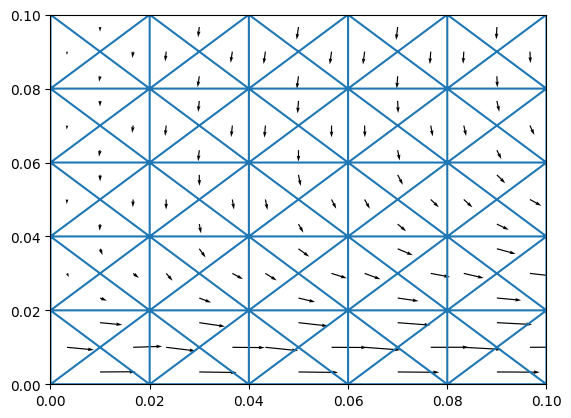

In [17]:
xy = np.array([data["CELL"][0,i][4][0][:,0] for i in range(data["CELL"].size)])
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel 
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.quiver(x,y,vel[:,0],vel[:,1],scale=1)
plt.axis([0,.1,0,.1])
xy = np.asarray([data["NODE"][0,i][2,0][:,0] for i in range(data["NODE"].size)])
x = xy[:,0]
y = xy[:,1]
tri = np.asarray([data["CELL"][0,i][6:9][:,0] for i in range(data["CELL"].size)])-1
plt.triplot(x,y,tri)
plt.axis([0,.1,0,.1])
plt.show()

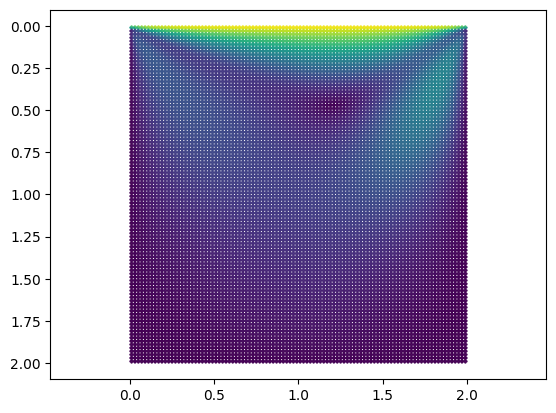

In [18]:
xy = np.array([data["CELL"][0,i][4][0][:,0] for i in range(data["CELL"].size)])
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.scatter(x,y,c=mag,cmap='viridis',vmin=0,vmax=U_lid,s=.5)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

In [19]:
from scipy.interpolate import NearestNDInterpolator
interp = NearestNDInterpolator(xy, vel)

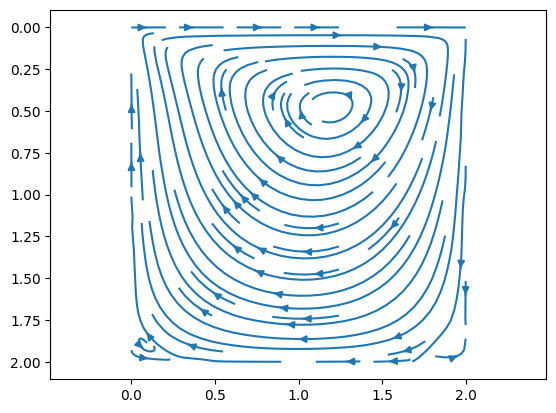

In [20]:
x = np.linspace(0, 2, 1000)
y = np.linspace(0, 2, 1000)
x,y = np.meshgrid(x, y)
vel = interp(x,y)
plt.streamplot(x, y, vel[:,:,0], vel[:,:,1],density=1)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

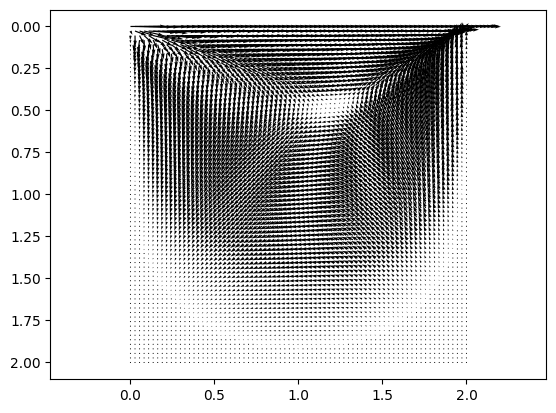

In [21]:
x = np.linspace(0, 2, 75)
y = np.linspace(0, 2, 75)
x,y = np.meshgrid(x, y)
vel = interp(x,y)
plt.quiver(x,y,vel[:,:,0],vel[:,:,1],scale=1)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

In [22]:
from scipy.io import loadmat
ref_data = loadmat('../ref/ldc_Re100.mat')
refu = ref_data['u'].T[...,jnp.newaxis]
refv = ref_data['v'].T[...,jnp.newaxis]
refx = ref_data['x'].squeeze()
refy = ref_data['y'].squeeze()
# x,y = jnp.meshgrid(x,y)
# x = jnp.expand_dims(x.flatten(),axis=-1)
# y = jnp.expand_dims(y.flatten(),axis=-1)
# xy = jnp.concatenate((x,y),axis=-1)
sol = jnp.concatenate((refu,refv),axis=-1)
solx = sol[128,:,1]
soly = sol[:,128,0]

In [23]:
x = np.linspace(0, 2, 1000)
y = np.linspace(0, 2, 1000)
outx = interp(x,np.ones_like(x))[...,1]/U_lid
outy = interp(np.ones_like(y),y)[...,0]/U_lid

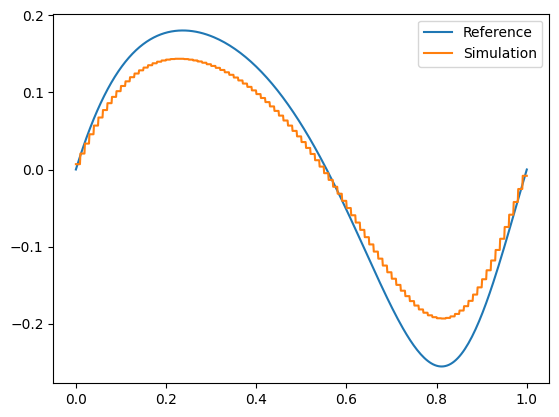

In [24]:
plt.plot(refy,solx)
plt.plot(x/2,-outx)
plt.legend(['Reference','Simulation'])
plt.show()

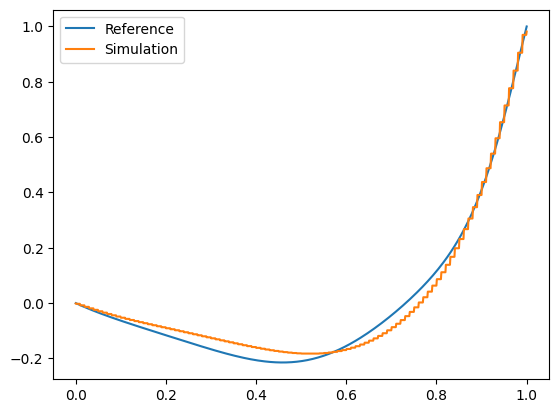

In [25]:
plt.plot(refy,soly)
plt.plot(np.flip(y)/2,outy)
plt.legend(['Reference','Simulation'])
plt.show()